In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score 
from sklearn import metrics
from statistics import mean
import pandas as pd

In [36]:
data=pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv')
data=data.sample(frac=1)   #random shuffling

In [37]:
data.head(10)

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
30964,30965,2013,7,14,4,99.0,22,24.0,1008.0,SE,50.53,0,0
29818,29819,2013,5,27,10,65.0,15,19.0,1009.0,NE,1.79,0,0
17894,17895,2012,1,16,14,NaN,-9,-1.0,1019.0,cv,1.78,0,0
7572,7573,2010,11,12,12,92.0,-5,-1.0,1016.0,NW,153.30,0,0
26154,26155,2012,12,25,18,NaN,-23,-8.0,1038.0,NE,3.57,0,0
41455,41456,2014,9,24,7,11.0,17,17.0,1017.0,NW,1.79,0,0
9054,9055,2011,1,13,6,149.0,-19,-10.0,1022.0,NW,9.39,0,0
28667,28668,2013,4,9,11,13.0,-13,12.0,1021.0,NW,302.19,0,0
33965,33966,2013,11,16,5,71.0,-8,8.0,1014.0,NW,6.26,0,0
5315,5316,2010,8,10,11,17.0,12,30.0,1007.0,SE,1.79,0,0


In [38]:
data.isna().sum().sum()

2067

In [39]:
data = data.dropna()
data.head()

one_hot=pd.get_dummies(data['cbwd'])
data=data.drop('cbwd',axis = 1)
data=data.join(one_hot)
data=data.drop(['No'],axis=1) #dropping number of rows
data.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir,NE,NW,SE,cv
30964,2013,7,14,4,99.0,22,24.0,1008.0,50.53,0,0,0,0,1,0
29818,2013,5,27,10,65.0,15,19.0,1009.0,1.79,0,0,1,0,0,0
7572,2010,11,12,12,92.0,-5,-1.0,1016.0,153.30,0,0,0,1,0,0
41455,2014,9,24,7,11.0,17,17.0,1017.0,1.79,0,0,0,1,0,0
9054,2011,1,13,6,149.0,-19,-10.0,1022.0,9.39,0,0,0,1,0,0


In [40]:
data.isna().sum().sum()
#all nan rows dropped

print(len(data))

41757


In [41]:
def train_val_test_split(data,labels, train,val,test):
    """ a function that will get dataset and training dataset fraction as input and return x_train, x_test, y_train, y_test """
    
    print("Total length is "+str(len(data)))
    
    train_samples=len(data)*train//(train+test+val)
    val_samples=len(data)*val//(train+test+val)
    
    
    train_data=data[:train_samples]
    train_labels=labels[:train_samples]
    
    val_data=data[train_samples+1:train_samples+val_samples+1]
    val_labels=labels[train_samples+1:train_samples+val_samples+1]
    
    test_data=data[train_samples+val_samples:]
    test_labels=labels[train_samples+val_samples:]
    
    return train_data,train_labels,val_data,val_labels,test_data,test_labels

In [42]:
labels=data['month']
data=data.drop(['month'],axis=1)

In [43]:
x_train,y_train,x_val,y_val,x_test,y_test=train_val_test_split(data,labels,70,15,15)

Total length is 41757


In [52]:
gini_tree=DecisionTreeClassifier(criterion="gini")
gini_tree.fit(x_train,y_train)
acc=gini_tree.score(x_test,y_test)

print("Accuracy using gini index is "+str(acc))

Accuracy using gini index is 0.8215482841181165


In [53]:
entropy_tree=DecisionTreeClassifier(criterion="entropy")
entropy_tree.fit(x_train,y_train)
acc=entropy_tree.score(x_test,y_test)

print("Accuracy using entropy is "+str(acc))

Accuracy using entropy is 0.8233040702314446


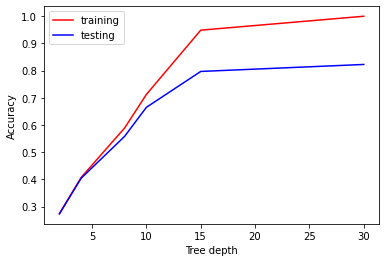

In [55]:
#for different depth
#using entropy as it gives more accuracy

depth_array=[2,4,8,10,15,30]
train_acc=[]
test_acc=[]

for i in depth_array:
    entropy_tree=DecisionTreeClassifier(criterion="entropy",max_depth=i)
    entropy_tree.fit(x_train,y_train)
    training=entropy_tree.score(x_train,y_train)
    testing=entropy_tree.score(x_test,y_test)
    train_acc.append(training)
    test_acc.append(testing)
    
plt.plot(depth_array,train_acc,'r',label='training')
plt.plot(depth_array,test_acc,'b',label='testing')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [79]:
def max_vote(predictions):
    final_prediction=[]
    for j in range(len(predictions[0])):
        maxi={}
        for i in predictions:
            if(i[j] in maxi):
                maxi[i[j]]+=1
            else:
                maxi[i[j]]=1
        max_key=max(maxi, key= lambda x: maxi[x])
        final_prediction.append(max_key)
    
    return final_prediction

stumps=[]
predictions=[]
for i in range(100):
    stumps.append(DecisionTreeClassifier(criterion="entropy",max_depth=3))
    x_train_frac=x_train.sample(frac=0.5)
    y_train_frac=y_train.loc[x_train_frac.index]
    stumps[i].fit(x_train,y_train)
    predicts=stumps[i].predict(x_test)
    predictions.append(predicts)

final_prediction=max_vote(predictions)
accuracy=np.sum(np.array(final_prediction)==np.array(y_test.to_list()))/len(y_test)

print("Accuracy obtained is "+str(accuracy))

Accuracy obtained is 0.3599361532322426


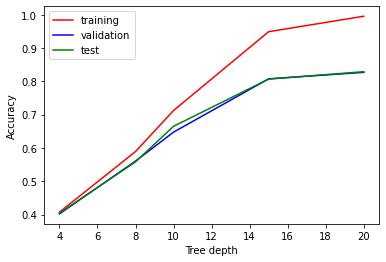

In [84]:
train_accuracies=[]
val_accuracies=[]
test_accuracies=[]

depth=[4,8,10,15,20]
for d in depth:
    stumps=[]
    predictions=[]
    val_predictions=[]
    test_predictions=[]
    for i in range(100):
        stumps.append(DecisionTreeClassifier(criterion="entropy",max_depth=d))
        x_train_frac=x_train.sample(frac=0.5)
        y_train_frac=y_train.loc[x_train_frac.index]
        stumps[i].fit(x_train,y_train)

        predictions.append(stumps[i].predict(x_train))        
        val_predictions.append(stumps[i].predict(x_val))
        test_predictions.append(stumps[i].predict(x_test))
        
    final_prediction=max_vote(predictions)
    final_val_prediction=max_vote(val_predictions)
    final_test_prediction=max_vote(test_predictions)
    
    accuracy=np.sum(np.array(final_prediction)==np.array(y_train.to_list()))/len(y_train)
    val_accuracy=np.sum(np.array(final_val_prediction)==np.array(y_val.to_list()))/len(y_val)
    test_accuracy=np.sum(np.array(final_test_prediction)==np.array(y_test.to_list()))/len(y_test)
    
    train_accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    test_accuracies.append(test_accuracy)
    
plt.plot(depth,train_accuracies,'r',label='training')
plt.plot(depth,val_accuracies,'b',label='validation')
plt.plot(depth,test_accuracies,'g',label='test')
plt.xlabel('Tree depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

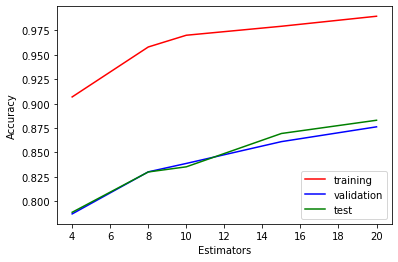

In [89]:
estimators = [4, 8, 10, 15, 20]
train_accuracies=[]
val_accuracies=[]
test_accuracies=[]

for e in estimators:
    model=AdaBoostClassifier(n_estimators=e,base_estimator=DecisionTreeClassifier(criterion="entropy",max_depth=11))
    model.fit(x_train, y_train)
    train_accuracies.append(model.score(x_train, y_train))
    val_accuracies.append(model.score(x_val, y_val))
    test_accuracies.append(model.score(x_test , y_test))
    
plt.plot(depth,train_accuracies,'r',label='training')
plt.plot(depth,val_accuracies,'b',label='validation')
plt.plot(depth,test_accuracies,'g',label='test')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()